### Monitorización de la deriva

Realizaremos la monitorización sobre las observaciones de 2024, pues los datos recopilados de las predicciones son muy escasos

#### Importamos librerías necesarias

In [131]:
import sys
sys.path.append("../")

In [132]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import pandas as pd

Cargamos los datos de forecast y las observaciones que hemos usado para entrenamiento

In [133]:
df_train = pd.read_parquet("../clean/df_definitivo.parquet")

df_new = pd.read_parquet("../clean/df_merged_2024.parquet")

# eliminamos repetidas, columnas que no participan en el modelo
df_train.drop(columns=['Temperatura', 'wspd'], inplace=True) 

df_new.drop(columns=['Temperatura', 'wspd'], inplace=True) 

##### Diferencia en tamaño

In [4]:
df_train.shape, df_new.shape

((12810, 36), (1400, 36))

Al haber una gran diferencia del tamaño, vamos a escoger los mismos meses del año que están en el df_new para que el tamaño del conjunto train no sea 10 veces más grande

In [7]:
df_train = df_train[df_train.mes.isin(df_new.mes.unique())]

In [8]:
df_train.shape, df_new.shape

((4716, 36), (1400, 36))

Hemos podido reducir la diferencia en cantidad bastante, además ahora son condiciones más igualadas al trabajar con los mismos meses

## Distribución las variables explicativas más importantes
Nos fijaremos en las importancias de las variables del bosque

Vamos a tener que recuperar el scaler para poder conseguir el orden correcto de las columnas
(ColumnTransformer cambia de orden las columnas asi que no son lo mismo las columnas de df SIN escalar y df CON escaldo)

In [19]:
X_train, y_train = df_train.drop(columns=['AlturaOlas', 'anio', 'mes', 'dia', 'hora']), df_train['AlturaOlas']

scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')
cols_order = scaler.fit_transform(X_train).columns
cols_order

Index(['moonphase', 'temp', 'dewPt', 'heat_index', 'rh', 'pressure', 'vis',
       'wc', 'feels_like', 'uv_index', 'Vviento', 'PeriodoOlas', 'Lluvia',
       'Nubosidad', 'wdir_E', 'wdir_ENE', 'wdir_ESE', 'wdir_N', 'wdir_NE',
       'wdir_NNE', 'wdir_NNW', 'wdir_NW', 'wdir_S', 'wdir_SE', 'wdir_SSE',
       'wdir_SSW', 'wdir_SW', 'wdir_VAR', 'wdir_W', 'wdir_WNW', 'wdir_WSW'],
      dtype='object')

Cargamos el modelo que hemos seleccionado como el mejor

In [20]:
filename = '../modelos/modelo_definitivo/modelo_rf_def.pkl'

with open(filename, 'rb') as file:
    model = pickle.load(file)


/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Mostramos las importancias de las variables del modelo

Text(0.5, 1.0, 'Importancias de variables de modelo')

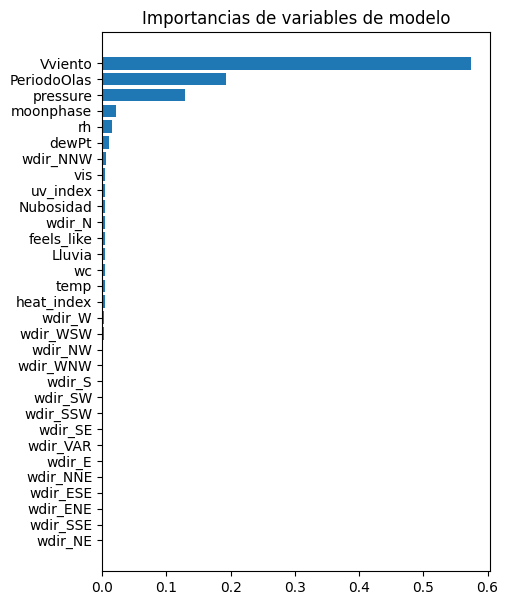

In [21]:
plt.figure(figsize=(5,7))
importancias = pd.DataFrame({'value': model.feature_importances_,'name': cols_order})
importancias = importancias.sort_values(by='value')
plt.barh(y=importancias.name, width=importancias.value)
plt.title('Importancias de variables de modelo')

Según el gráfico, vemos que las tres variables con mayor importancia (con diferencia, además) son la velocidad del viento (Vviento), el período de las olas (PeriodoOlas) y la presión atmosférica (pressure). 

In [51]:
imp_cols = ['Vviento', 'PeriodoOlas', 'pressure']

#### Usando métricas agregadas para evaluar las diferencias

### 1. VViento
(nudos)

In [60]:
var = 'Vviento'

Analisis por distintos valores estadísticos

In [67]:
df = pd.concat([df_train[var].describe(), df_new[var].describe()], axis=1)
df.columns = ['OLD ' + var, 'NEW ' + var]
df

,OLD Vviento,NEW Vviento
count,4716.000000,1400.000000
mean,10.723919,12.931429
std,5.516975,6.381566
min,0.000000,1.000000
25%,7.000000,8.000000
50%,10.000000,12.000000
75%,14.000000,17.000000
max,36.000000,42.000000


### 2. PeriodoOlas
(segundos)

In [68]:
var = 'PeriodoOlas'

Analisis por distintos valores estadísticos

In [69]:
df = pd.concat([df_train[var].describe(), df_new[var].describe()], axis=1)
df.columns = ['OLD ' + var, 'NEW ' + var]
df

,OLD PeriodoOlas,NEW PeriodoOlas
count,4716.000000,1400.000000
mean,8.332061,7.729286
std,3.165629,2.715797
min,0.000000,1.000000
25%,6.000000,6.000000
50%,8.000000,8.000000
75%,10.000000,10.000000
max,19.000000,15.000000


### 3. PRESION
(inHg, pulgadas de mercurio)

In [70]:
var = 'pressure'

Analisis por distintos valores estadísticos

In [71]:
df = pd.concat([df_train[var].describe(), df_new[var].describe()], axis=1)
df.columns = ['OLD ' + var, 'NEW ' + var]
df

,OLD pressure,NEW pressure
count,4716.000000,1400.000000
mean,29.927596,29.701582
std,0.371725,0.452594
min,28.730000,28.460000
25%,29.685000,29.415000
50%,29.960000,29.715000
75%,30.230000,30.050000
max,30.790000,30.610000


## Distribución las alturas de las olas

Empezamos con los histogramas

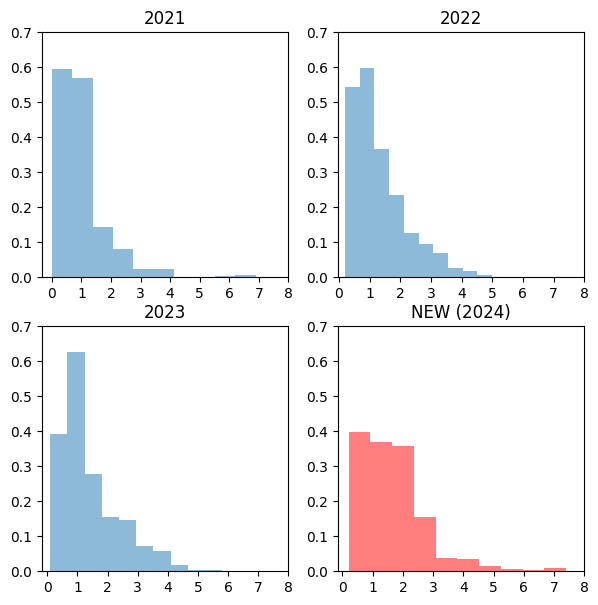

In [130]:
fig, axs = plt.subplots(2,2, figsize=(7,7))
for i, year in enumerate(df_train.anio.unique()):
    axs[i//2, i%2].hist(df_train[df_train.anio == year]['AlturaOlas'], density=True, alpha=0.5)
    axs[i//2, i%2].set_title(year)
    axs[i//2, i%2].set_xticks([i for i in range(0,9,1)])
    axs[i//2, i%2].set_yticks([i/10 for i in range(0,8,1)])

axs[1,1].hist(df_new['AlturaOlas'], density=True, alpha=0.5, label='NEW (2024)', color='red')
axs[1,1].set_title('NEW (2024)')
axs[1,1].set_xticks([i for i in range(0,9,1)])
axs[1,1].set_yticks([i/10 for i in range(0,8,1)])


In [74]:
def class_ola(ola):
    if (ola < 1):
        return "x<1"
    if (ola < 2):
        return "1<x<2"
    if (ola < 3):
        return "2<x<3"
    else:
        return "x>3"

In [103]:
segmentos_train = df_train.AlturaOlas.map(class_ola)
segmentos_new = df_new.AlturaOlas.map(class_ola)

array([2021, 2022, 2023])

A parte de analizarlo con el conjunto total, lo analizaremos por años

In [ ]:
df_train.anio.unique()

In [104]:
segmentos_train_2021 = df_train[df_train.anio == 2021].AlturaOlas.map(class_ola)
segmentos_train_2022 = df_train[df_train.anio == 2022].AlturaOlas.map(class_ola)
segmentos_train_2023 = df_train[df_train.anio == 2023].AlturaOlas.map(class_ola)

<Axes: title={'center': 'NEW'}>

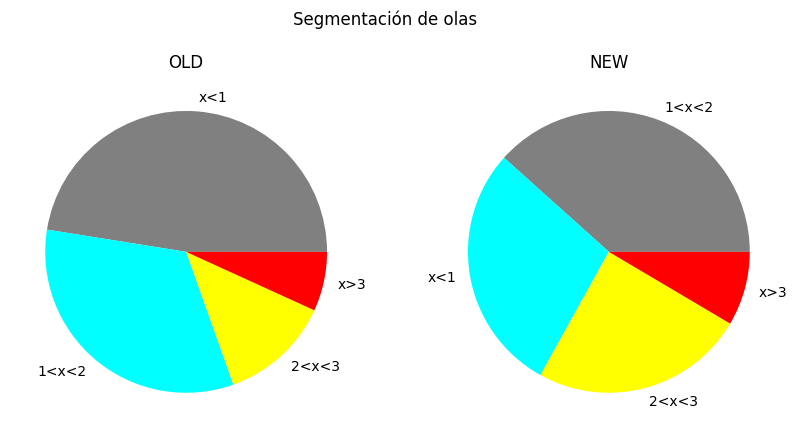

In [105]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Segmentación de olas')
segmentos_train.value_counts().plot(ax=axs[0], kind='pie', label='', title='OLD', colors=['gray', "aqua", "yellow", "red"])

segmentos_new.value_counts().plot(ax=axs[1], kind='pie', label='', title='NEW', colors=['gray', "aqua", "yellow", "red"])

Text(0, 0.5, 'Cantidad')

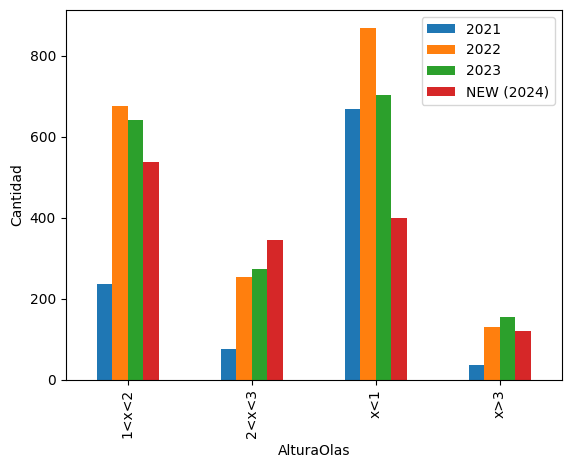

In [106]:
df = pd.DataFrame({
    '2021':  segmentos_train_2021.value_counts(),
    '2022':  segmentos_train_2022.value_counts(),
    '2023':  segmentos_train_2023.value_counts(),
    'NEW (2024)': segmentos_new.value_counts()
})

df.plot(kind='bar', stacked=False)
plt.ylabel('Cantidad')